아래 사항은 한 번 설치하여 성공으로 끝나면 다시 실행할 필요가 없습니다.

In [ ]:
#  !pip install cmdstanpy

import cmdstanpy
cmdstanpy.install_cmdstan(compiler=True)  # Uncomment this line if CmdStan is not installed

Defaulting to user installation because normal site-packages is not writeable


C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
23:03:12 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\yongd\.cmdstan\RTools40


CmdStan install directory: C:\Users\yongd\.cmdstan
CmdStan version 2.37.0 already installed
Test model compilation


True

In [ ]:
import os
print("CMDSTAN path:", os.environ.get("CMDSTAN"))

print("PATH entries containing 'RTools':") # Check for RTools in PATH, Windows specific
path_list = os.environ.get("PATH", "").split(os.pathsep)
for p in path_list:
    if "RT" in p:
        print(p)

CMDSTAN path: C:\Users\yongd\.cmdstan\cmdstan-2.37.0


In [2]:
stan_code = """
data {
  // N is the total number of trials (80 + 20 = 100)
  int<lower=0> N; 
  // y is the number of "successes" (80)
  int<lower=0, upper=N> y; 
}

parameters {
  // theta is the parameter we want to sample, constrained between 0 and 1
  real<lower=0, upper=1> theta;
}

transformed parameters {
  // Define the probability of success 'p' based on the relationship 
  // from the likelihood function: p = (1 + theta) / 2
  real<lower=0, upper=1> p = (1.0 + theta) / 2.0;
}

model {
  // 1. PRIOR (Prior(theta) = theta^3 * (1-theta))
  // This is proportional to a Beta(4, 2) distribution 
  // (since Beta(a, b) is proportional to theta^(a-1) * (1-theta)^(b-1))
  target += beta_lpdf(theta | 4, 2);
  
  // 2. LIKELIHOOD (L(theta) = ((1+theta)/2)^80 * ((1-theta)/2)^20)
  // This is the log probability mass function (lpmf) of a Binomial distribution
  // with 'y' successes out of 'N' trials and success probability 'p'.
  target += binomial_lpmf(y | N, p);
  
  // Stan automatically combines the log-prior and log-likelihood to sample 
  // from the unnormalized log-posterior distribution.
}
"""

stan_file = 'bayes_model.stan'
with open(stan_file, 'w') as f:
    f.write(stan_code)


In [3]:
# Stan code using '~' notation for prior and likelihood
stan_code_simple = """
data {
  int<lower=0> N;
  int<lower=0, upper=N> y;
}
parameters {
  real<lower=0, upper=1> theta;
}
transformed parameters {
  real<lower=0, upper=1> p = (1.0 + theta) / 2.0;
}

// Note: 'y' is the observed data, so we may use '~' notation even if the probability model is a discrete PMF.
model {
  theta ~ beta(4, 2);
  y ~ binomial(N, p); 
}
"""
stan_file_simple = 'bayes_model_simple.stan'
with open(stan_file_simple, 'w') as f:
    f.write(stan_code_simple)


In [4]:
import cmdstanpy
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Define Data and Model ---

# Data corresponding to the likelihood function:
# L(theta) = ((1+theta)/2)^80 * ((1-theta)/2)^20
stan_data = {
    'N': 100,  # Total trials: 80 + 20
    'y': 80    # Successes
}

# stan_file = 'bayesian_model.stan'
model_name = os.path.splitext(stan_file)[0]
print(f"Model name: {model_name}")


C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model name: bayes_model


In [5]:
# --- 2. Compile and Instantiate Model ---
try:
    print(f"Compiling Stan model: {stan_file}...")
    model = cmdstanpy.CmdStanModel(stan_file=stan_file)
    print("Model compiled successfully.")
except Exception as e:
    print(f"Error compiling Stan model: {e}")
    print("Please ensure CmdStan is installed and configured correctly.")
    exit()


23:14:39 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\KOS6002\bayes_model.stan to exe file C:\Users\yongd\Documents\git\KOS6002\bayes_model.exe


Compiling Stan model: bayes_model.stan...


23:14:47 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\KOS6002\bayes_model.exe


Model compiled successfully.


In [6]:
model

CmdStanModel: name=bayes_model
	 stan_file=C:\Users\yongd\Documents\git\KOS6002\bayes_model.stan
	 exe_file=C:\Users\yongd\Documents\git\KOS6002\bayes_model.exe
	 compiler_options=stanc_options={}, cpp_options={}

In [7]:
# --- 3. Run MCMC Sampling (HMC) ---
try:
    print("Starting HMC sampling...")
    fit = model.sample(
        data=stan_data,
        chains=4,          # Run 4 independent Markov chains
        iter_warmup=1000,  # Burn-in period
        iter_sampling=2000, # Number of samples to draw after warmup
        seed=1234          # For reproducibility
    )
    print("Sampling completed.")
except Exception as e:
    print(f"Error during sampling: {e}")
    exit()



Starting HMC sampling...


23:14:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


23:14:48 - cmdstanpy - INFO - CmdStan done processing.



Sampling completed.


In [8]:
summary = fit.summary()
summary

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-3.684080,0.012119,0.717191,0.309254,-5.146970,-3.408520,-3.184250,3873.16,4944.87,43035.1,1.00014
theta,0.604843,0.001395,0.073181,0.073273,0.479390,0.607865,0.720793,2764.76,4072.70,30719.5,1.00015
p,0.802422,0.000698,0.036591,0.036636,0.739695,0.803932,0.860396,2764.76,4072.70,30719.5,1.00015


In [9]:
df = fit.draws_pd()
theta_samples = df['theta'].values

Theta summary statistics:
Mean              0.604843
MCSE              0.001395
StdDev            0.073181
MAD               0.073273
5%                0.479390
50%               0.607865
95%               0.720793
ESS_bulk       2764.760000
ESS_tail       4072.700000
ESS_bulk/s    30719.500000
R_hat             1.000150
Name: theta, dtype: float64


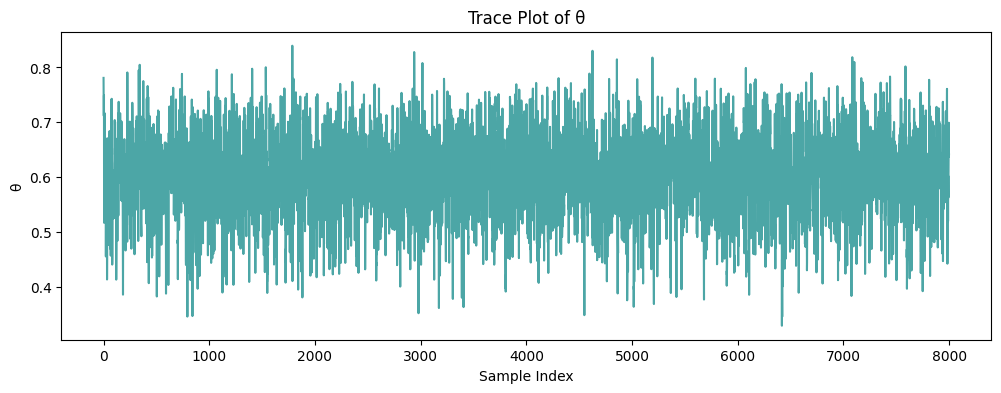

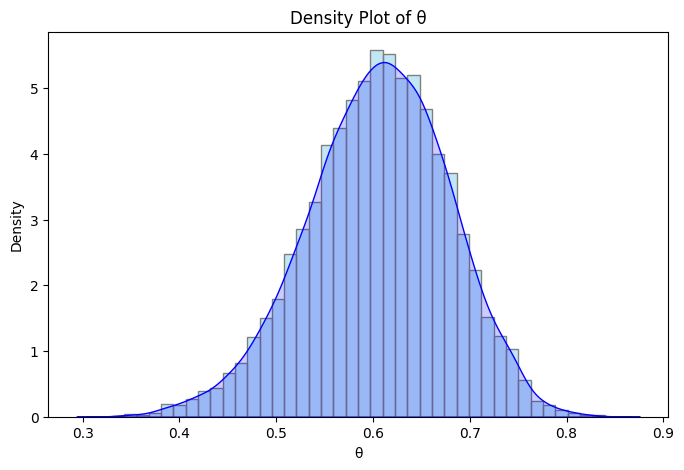

In [10]:
import seaborn as sns


# --- 4. Analyze and Plot Results ---

# Extract samples of theta (parameters are stored in an xarray dataset)
theta_samples = fit.stan_variable('theta')

# Flatten all chains into a single array for plotting
all_samples = theta_samples.flatten()
theta_summary = summary.loc['theta']
print("Theta summary statistics:")
print(theta_summary)

# Trace plot of theta
plt.figure(figsize=(12, 4))
plt.plot(all_samples, color='teal', alpha=0.7)
plt.title('Trace Plot of θ')
plt.xlabel('Sample Index')
plt.ylabel('θ')
plt.show()

# Density plot of theta (KDE only)
plt.figure(figsize=(8, 5))
sns.histplot(all_samples, bins=40, color='skyblue', stat='density', alpha=0.5, edgecolor='gray')
sns.kdeplot(all_samples, color='blue', fill=True, alpha=0.2)
plt.title('Density Plot of θ')
plt.xlabel('θ')
plt.ylabel('Density')
plt.show()

23:14:49 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\KOS6002\bayes_model_simple.stan to exe file C:\Users\yongd\Documents\git\KOS6002\bayes_model_simple.exe
23:14:57 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\KOS6002\bayes_model_simple.exe
23:14:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


23:14:57 - cmdstanpy - INFO - CmdStan done processing.


23:14:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


23:14:57 - cmdstanpy - INFO - CmdStan done processing.



Original Stan code summary:
           Mean      MCSE    StdDev       MAD        5%       50%       95%  \
lp__  -3.684080  0.012119  0.717191  0.309254 -5.146970 -3.408520 -3.184250   
theta  0.604843  0.001395  0.073181  0.073273  0.479390  0.607865  0.720793   
p      0.802422  0.000698  0.036591  0.036636  0.739695  0.803932  0.860396   

       ESS_bulk  ESS_tail  ESS_bulk/s    R_hat  
lp__    3873.16   4944.87     45036.7  1.00014  
theta   2764.76   4072.70     32148.3  1.00015  
p       2764.76   4072.70     32148.3  1.00015  
Simple Stan code summary:
            Mean      MCSE    StdDev       MAD         5%        50%  \
lp__  -54.409500  0.011580  0.704467  0.314052 -55.835900 -54.140500   
theta   0.605337  0.001315  0.073120  0.074012   0.479227   0.607866   
p       0.802668  0.000657  0.036560  0.037006   0.739613   0.803933   

             95%  ESS_bulk  ESS_tail  ESS_bulk/s     R_hat  
lp__  -53.910300   3984.49   4929.25     49806.1  0.999946  
theta   0.719541   30

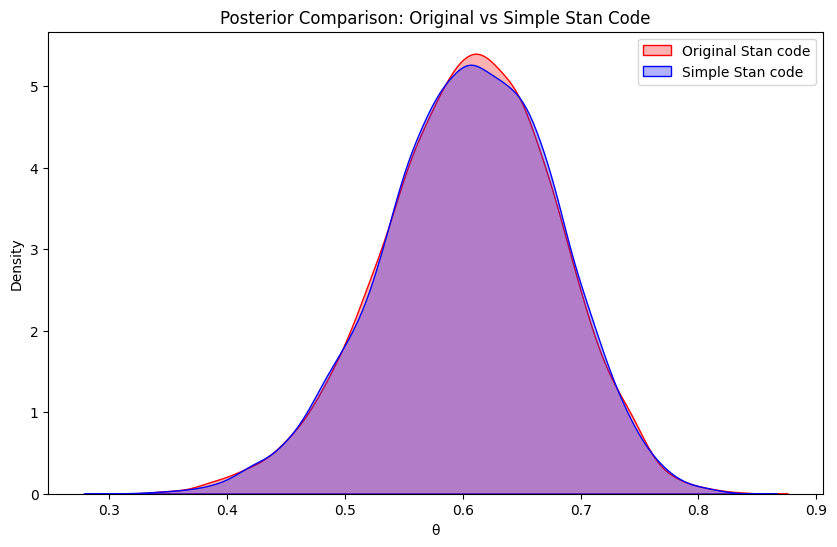

In [11]:
# --- Comparison of Stan Models ---
import pandas as pd

# Compile both models
model_original = cmdstanpy.CmdStanModel(stan_file='bayes_model.stan')
model_simple = cmdstanpy.CmdStanModel(stan_file='bayes_model_simple.stan')

# Sample from both models
fit_original = model_original.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=2000, seed=1234)
fit_simple = model_simple.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=2000, seed=1234)

# Extract theta samples
theta_orig = fit_original.stan_variable('theta').flatten()
theta_simp = fit_simple.stan_variable('theta').flatten()

# Print summary statistics
print('Original Stan code summary:')
print(fit_original.summary())
print('Simple Stan code summary:')
print(fit_simple.summary())

# Plot comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(theta_orig, color='red', label='Original Stan code', fill=True, alpha=0.3)
sns.kdeplot(theta_simp, color='blue', label='Simple Stan code', fill=True, alpha=0.3)
plt.title('Posterior Comparison: Original vs Simple Stan Code')
plt.xlabel('θ')
plt.ylabel('Density')
plt.legend()
plt.show()

끝.